In [32]:
import mesa
from functional import seq
import random

from dataclasses import dataclass

In [33]:
from typing import Tuple, Optional, List, Any, Dict

In [34]:
import matplotlib.pyplot as plt
import numpy as np

In [35]:
import networkx as nx
import json

# Locations

In [36]:
@dataclass
class Hotel():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0
    thotel: float
    photel: float

    # stats
    new_rev: int = 0
    total_rev: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied
    
   

In [37]:
@dataclass
class ShortTermHousing():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    new_rev: int = 0
    total_rev: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

In [38]:
@dataclass
class PointOfInterest():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0
    tentry: float
    pentry: float


    # stats
    visit: int = 0
    total_visit: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

# Tourist

In [8]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.poi :Optional[PointOfInterest] = None

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -=1
        if self.hotel is None and self.remaining_life >= 3:
            hotels = (
                seq(self.model.hotels)
                    .filter(lambda h: h.remaining_capacity() >= 0)
                    .list()
            )

            if len(hotels) <= 0:
                self.remaining_life = -1
                return;

            random_index = random.randint(0, len(hotels) - 1)
            self.hotel = hotels[random_index]

            self.hotel.occupied += 1
            self.hotel.new_rev += 1
            self.hotel.total_rev += 1

            return

            # print("Looking for point of interest")
        random_index = random.randint(0, len(self.model.pois) - 1)

        poi: PointOfInterest = self.model.pois[random_index]

        # Travel logic

        poi.occupied+=1
        poi.visit+=1

        if self.poi is not None:
            self.poi.occupied -=1

        self.poi = poi
        return
    def go_home(self):
        # Travel back to hotel
        if self.poi is not None:
            self.poi.occupied -=1
        self.poi = None
        pass


## Growth Models

In [9]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [10]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model, i: int = 1) -> List[Tourist]:
        return Tourist(id, model, 0, max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length))))

In [11]:
@dataclass
class SeasonalTouristInflow:
    inflows: List[RandomTouristInflow]
    season_lengths: List[int]

    counter: int = 0

    def new_pops(self) -> int:
        self.counter= (self.counter+1)%sum(self.season_lengths)

        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )


        return self.inflows[current_season].new_pops()

    def new_tourist(self, id: int, model, i: int = 0) -> List[Tourist]:
        
        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )

        return self.inflows[current_season].new_tourist(id, model)


In [12]:
@dataclass
class CruiseShipInflow:
    group_size: int
    trip_length: int
    arrival_interval: int

    counter: int = 0

    def new_pops(self) -> int:
        self.counter = (self.counter + 1 ) % self.arrival_interval
        if self.counter  == 0:
            return self.group_size
        return 0

    def new_tourist(self, id: int, model) -> List[Tourist]:
        return Tourist(id, model, 0, self.trip_length)


In [13]:

@dataclass
class UnionInflow:
    inflows: List[Any]

    def new_pops(self) -> int:
        return seq(self.inflows).map(lambda i: i.new_pops()).sum()

    def new_tourist(self, id: int, model) -> List[Tourist]:
        tourists = []
        for inflow in self.inflows:
            tourists.extend(inflow.new_tourist(id, model, i = i))
        return tourists

# Mapping

In [39]:
@dataclass
class Node:
    id: int
    lat: float
    lon: float

In [40]:
import tripy
from dataclasses import field
from functional import seq
from pyproj import Proj, Transformer

@dataclass(unsafe_hash=True)
class Building:
    id: int = field(compare=True) 
    nodes: List[Node] = field(compare=False) 
    tags: Dict[str, Any] = field(compare=False) 

    def __post_init__(self):
        self.transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    def triangulate(self) -> List[Tuple[Tuple[float, float]]]:
        return tripy.earclip(
            seq(self.nodes)
                .map(lambda x: (x.lon, x.lat))
                .take(len(self.nodes) - 1)
                .list()
            )
    
    def get_centroid(self) -> Tuple[float, float]:
        triangles = self.triangulate()
        total_area = 0
        centroid_x = 0
        centroid_y = 0

        for triangle in triangles:
            p1, p2, p3 = triangle
            
            # Calculate the centroid of the triangle
            tri_centroid_x = (p1[0] + p2[0] + p3[0]) / 3
            tri_centroid_y = (p1[1] + p2[1] + p3[1]) / 3

            # Calculate the area of the triangle
            tri_area = self._triangle_area(p1, p2, p3)

            # Accumulate weighted centroids
            centroid_x += tri_centroid_x * tri_area
            centroid_y += tri_centroid_y * tri_area
            total_area += tri_area

        # Final centroid is the weighted average of all triangle centroids
        if total_area == 0:
            raise ValueError("The building's area is zero. Centroid cannot be calculated.")

        return centroid_x / total_area, centroid_y / total_area
    
    def contains(self, lon: float, lat: float) -> bool:# Get the triangles from the triangulate method
        triangles = self.triangulate()

        for triangle in triangles:
            if self._point_in_triangle((lon, lat), triangle):
                return True
        return False
    
    def get_area(self) -> float:
        """Calculate the total area of the building in square meters."""
        triangles = self.triangulate()
        total_area = 0

        for triangle in triangles:
            # Convert triangle vertices from lat/lon to meters
            p1 = self._to_meters(triangle[0])
            p2 = self._to_meters(triangle[1])
            p3 = self._to_meters(triangle[2])

            # Add the triangle's area in square meters
            total_area += self._triangle_area(p1, p2, p3)

        return total_area

    def _to_meters(self, point: Tuple[float, float]) -> Tuple[float, float]:
        """Convert a point (lon, lat) to meters using the UTM projection."""
        lon, lat = point
        return self.transformer.transform(lon, lat)
    
    @staticmethod
    def _triangle_area(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> float:
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2)

    @staticmethod
    def _point_in_triangle(point: Tuple[float, float], triangle: Tuple[Tuple[float, float]]):
        p1, p2, p3 = triangle
        
        total_area = Building._triangle_area(p1, p2, p3)

        area1 = Building._triangle_area(point, p2, p3)
        area2 = Building._triangle_area(p1, point, p3)
        area3 = Building._triangle_area(p1, p2, point)

        return abs(total_area - (area1 + area2 + area3)) < 1e-9

In [50]:
def load_from_json(file_path: str) -> Tuple[nx.Graph, List[Node], Dict[str, List[Building]]]:
    with open(file_path, "r") as file:
        data = json.load(file)
    
    # Reconstruct the graph from the data
    graph_data = data["graph"]
    graph: nx.Graph = nx.node_link_graph(graph_data)  # Converts the node-link format back into a NetworkX graph
    
    # Reconstruct nodes from the data
    nodes = (seq(data["nodes"].items())
        .map(lambda x: (int(x[0]), Node(**x[1])))
        .dict()
    )
    
    # Reconstruct buildings from the data
    buildings = {}
    for key, building_list in data["buildings"].items():
        building_objs = (seq(building_list)
            .map(lambda building_data: Building(
                id=building_data["id"],
                nodes=[Node(**node_data) for node_data in building_data["nodes"]],
                tags=building_data["tags"])
            )
            .filter(lambda building: graph.has_node(str(building.id)))
            .list()
        )
        buildings[key] = building_objs
    
    return graph, nodes, buildings



In [51]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the Haversine distance between two points on the Earth.
    Returns the distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 6371 for km or 3958.8 for miles)
    radius = 6371.0
    distance = radius * c
    return distance

shortest_path_cache = dict()
def find_shortest_path(G: nx.Graph, start_node_id: int, end_node_id: int) -> List[int]:
    """
    Finds the shortest path between two nodes in the graph based on Haversine distance.
    Returns the list of node IDs representing the shortest path from start_node_id to end_node_id.
    """
    # Define a custom weight function for the edges based on Haversine distance
    cache_key = (start_node_id, end_node_id)
    if cache_key in shortest_path_cache:
        return shortest_path_cache[cache_key]
    def haversine_weight(u, v, data):
        lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
        lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
        return haversine(lat1, lon1, lat2, lon2)
    
    try:
        # Using Dijkstra's algorithm with Haversine distance as weight
        shortest_path = nx.dijkstra_path(G, source=start_node_id, target=end_node_id, weight=haversine_weight)
        shortest_path_cache[cache_key] = shortest_path
        return shortest_path
    except nx.NetworkXNoPath:
        print(f"No path found between node {start_node_id} and node {end_node_id}.")
        shortest_path_cache[cache_key] = []
        return []

path_length_cache = dict()
def calculate_path_length(G: nx.Graph, path: List[int]) -> float:
    """
    Calculate the total Haversine distance of a given path in the graph.
    Returns the distance in kilometers.
    """
    path_cache_key = tuple(path)
    if path_cache_key in path_length_cache:
        return path_length_cache[path_cache_key]
    if len(path) < 2:
        return 0.0  # No distance to compute for a path with less than 2 nodes

    total_distance = 0.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
        lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
        total_distance += haversine(lat1, lon1, lat2, lon2)
    path_length_cache[path_cache_key] = total_distance
    return total_distance

# Tourist

In [52]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.poi: Optional[PointOfInterest] = None

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -= 1
        if self.hotel is None and self.remaining_life >= 3:
            # Try to find a hotel with available capacity
            hotels = (
                seq(self.model.hotels)
                    .filter(lambda h: h.remaining_capacity() > 0)  # Ensure rooms are available
                    .list()
            )

            # If no hotels are available, try short-term rentals
            if len(hotels) == 0:
                short_terms = (
                    seq(self.model.short_term[True])
                        .filter(lambda st: st.remaining_capacity() > 0)
                        .list()
                )

                # If a short-term rental is available, book it
                if len(short_terms) > 0:
                    random_index = random.randint(0, len(short_terms) - 1)
                    self.hotel = short_terms[random_index]
                    self.hotel.occupied += 1
                    self.hotel.new_rev += 1
                    self.hotel.total_rev += 1
                    return
                else:
                    # If neither hotel nor short-term rentals are available, the tourist leaves
                    self.remaining_life = -1
                    return

            # If hotels are available, book a room
            random_index = random.randint(0, len(hotels) - 1)
            self.hotel = hotels[random_index]
            self.hotel.occupied += 1
            self.hotel.new_rev += 1
            self.hotel.total_rev += 1

            return

        # Explore POI if the tourist has a hotel
        random_index = random.randint(0, len(self.model.pois) - 1)
        poi: PointOfInterest = self.model.pois[random_index]

        # Travel logic
        poi.occupied += 1
        poi.visit += 1

        if self.poi is not None:
            self.poi.occupied -= 1

        match (self.hotel, self.poi):
            case (None, None):
                # Edge case, just teleport to new POI
                pass
            case (None, start) | (start, None) | (_, start):
                path = find_shortest_path(self.model.graph, str(start.id), str(poi.id))
                dist = calculate_path_length(self.model.graph, path)

                self.model.road_traveled += dist
                self.model.co2_emissions[-1]["car"] += dist * 130.

        self.poi = poi
        return

    def go_home(self):
        # Travel back to hotel
        if self.poi is not None:
            self.poi.occupied -= 1

        match (self.hotel, self.poi):
            case (None, None) | (None, _):
                # Edge case, just teleport to new POI
                pass
            case (end, start):
                path = find_shortest_path(self.model.graph, str(start.id), str(end.id))
                dist = calculate_path_length(self.model.graph, path)

                self.model.road_traveled += dist
                self.model.co2_emissions[-1]["car"] += dist * 130.
        self.poi = None
        pass


## Growth Models

In [53]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [54]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model, i: int = 1) -> List[Tourist]:
        return Tourist(id, model, 0, max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length))))

In [55]:
@dataclass
class SeasonalTouristInflow:
    inflows: List[RandomTouristInflow]
    season_lengths: List[int]

    counter: int = 0

    def new_pops(self) -> int:
        self.counter= (self.counter+1)%sum(self.season_lengths)

        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )


        return self.inflows[current_season].new_pops()

    def new_tourist(self, id: int, model, i: int = 0) -> List[Tourist]:
        
        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )

        return self.inflows[current_season].new_tourist(id, model)


In [56]:
@dataclass
class CruiseShipInflow:
    group_size: int
    trip_length: int
    arrival_interval: int

    counter: int = 0

    def new_pops(self) -> int:
        self.counter = (self.counter + 1 ) % self.arrival_interval
        if self.counter  == 0:
            return self.group_size
        return 0

    def new_tourist(self, id: int, model) -> List[Tourist]:
        return Tourist(id, model, 0, self.trip_length)


In [57]:

@dataclass
class UnionInflow:
    inflows: List[Any]

    def new_pops(self) -> int:
        return seq(self.inflows).map(lambda i: i.new_pops()).sum()

    def new_tourist(self, id: int, model) -> List[Tourist]:
        tourists = []
        for inflow in self.inflows:
            tourists.extend(inflow.new_tourist(id, model, i = i))
        return tourists

In [58]:
graph, nodes, buildings = load_from_json("data.json")
print("Data loaded from output.json")
print(graph)
print(nodes)
print(buildings)

C:\Users\arine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Data loaded from output.json
Graph with 1865 nodes and 1997 edges
{65662330: Node(id=65662330, lat=58.3572959, lon=-134.5006807), 65662334: Node(id=65662334, lat=58.3575501, lon=-134.4999879), 65662335: Node(id=65662335, lat=58.3580109, lon=-134.4986801), 65662336: Node(id=65662336, lat=58.3584349, lon=-134.4974103), 65662337: Node(id=65662337, lat=58.358785, lon=-134.4960942), 65662340: Node(id=65662340, lat=58.3589842, lon=-134.4953102), 65662343: Node(id=65662343, lat=58.3590563, lon=-134.4950097), 65662344: Node(id=65662344, lat=58.3591421, lon=-134.4946605), 65662345: Node(id=65662345, lat=58.3592024, lon=-134.4944003), 65662347: Node(id=65662347, lat=58.3592507, lon=-134.4942126), 65662877: Node(id=65662877, lat=58.3614442, lon=-134.5154038), 65662878: Node(id=65662878, lat=58.3612941, lon=-134.5155917), 65662880: Node(id=65662880, lat=58.3612106, lon=-134.5159078), 65662882: Node(id=65662882, lat=58.3611788, lon=-134.5165755), 65662883: Node(id=65662883, lat=58.3611175, lon=-134

# Model

In [68]:
class Model(mesa.Model):
    def __init__(self, nodes, graph, buildings, inflow_model):
        self.hotels: List[Hotel] = []
        self.pois: List[PointOfInterest] = []

        self.short_term: Dict[bool, List[ShortTermHousing]] = {
            False: [],
            True: []
        }

        self.tourists: List[Tourist] = []

        self.schedule = mesa.time.RandomActivation(self)

        self.inflow = inflow_model

        # Stats
        self.hotel_stats = []
        self.poi_stats = []
        
        self.road_traveled = 0.

        self.co2_emissions = [{
            "car": 0,
            "air_plane": 0,
            "boat": 0,
        }]

        self.graph = graph
        self.nodes = nodes
        self.buildings = buildings

        print(len(buildings["residential"]))
        for residential in buildings["residential"]:
            self.short_term[False].append(
                ShortTermHousing(int(residential.id), 100, 5)
            )
        self.total_revenue = 0
        self.cost_infra = 0
        self.cost_env = 0

        print(len(buildings["lodging"]))
        for lodge in buildings["lodging"]:
            area = lodge.get_area()

            max_capacity = max(30, int(area / 1.5 * 0.01))
            self.hotels.append(Hotel(int(lodge.id), 100, max_capacity))

        pois_tag: List[str] = ["store", "restaurant", "night_club", "museum", "city_hall", "bar", "art_gallery", "tourist_attraction"]
        self.pois_building = []
        for tag in pois_tag:
            for building in buildings[tag]:
                area = building.get_area()

                max_capacity = max(10, int(area / 1.5 * 0.01))

                self.pois_building.append(building)
                self.pois.append(PointOfInterest(building.id, 200, max_capacity))

    def update_tourists(self):
        num_tourists = len(self.tourists)
        random_indices = set()

        # Generate a set of unique random indices
        while len(random_indices) < num_tourists:
            random_indices.add(random.randint(0, num_tourists - 1))

        # Access tourists in a random order using the indices
        for index in random_indices:
            tourist = self.tourists[index]
            tourist.step()
    def remove_tourists(self):
        remove_index: list[int] = (seq(self.tourists)
            .enumerate()
            .filter(lambda x: x[1].remaining_life < 0)
            .map(lambda x: x[0])
            .sorted(reverse=True)
            .list()
        )
        for i1 in remove_index:
            if self.tourists[i1].hotel:
                self.tourists[i1].hotel.occupied -=1

            del self.tourists[i1]
    def step(self):
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())
        net_profit=self.calculate_net_profit()
        print({f"Net profit is: {net_profit}."})

        self.remove_tourists()

        self.hotel_stats.append(self.get_hotel_stats())
        
        self.poi_stats.append(self.get_poi_stats())

        size = self.inflow.new_pops()
        for i in range(size):
            self.tourists.append(self.inflow.new_tourist(i, self))

        self.co2_emissions.append({
            "car": 0,
            "air_plane": 0,
            "boat": 0,
        })
    def get_poi_stats(self) -> Tuple[float, float, float, float]:
        # Calculate total capacity
        total_capacity: int = (seq(self.pois)
            .map(lambda p: p.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate empty slots (remaining capacity)
        empty_slots: int = (seq(self.pois)
            .map(lambda p: p.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate occupied slots
        occupied_slots: int = (seq(self.pois)
            .map(lambda p: p.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate new visits
        new_visits: int = (seq(self.pois)
            .map(lambda p: p.visit)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Reset new visits for the next time step
        for poi in self.pois:
            poi.visit = 0

        return (total_capacity, empty_slots, occupied_slots, new_visits)
    def get_hotel_stats(self) -> Tuple[float, float, float, float, float]:
        total_capacity: int = (seq(self.hotels)
            .map(lambda h: h.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )

        # Add short-term housing capacity to the total capacity
        total_capacity += (seq(self.short_term[True])
            .map(lambda st: st.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )

        empty_rooms: int = (seq(self.hotels)
            .map(lambda h: h.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )

        # Add short-term housing empty rooms
        empty_rooms += (seq(self.short_term[True])
            .map(lambda st: st.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )

        occupied_rooms: int = (seq(self.hotels)
            .map(lambda h: h.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        
        # Add short-term housing occupied rooms
        occupied_rooms += (seq(self.short_term[True])
            .map(lambda st: st.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )

        new_reservations: int = (seq(self.hotels)
            .map(lambda h: h.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )
        for hotel in self.hotels:
            hotel.new_rev = 0

        # Add new reservations for short-term rentals
        new_reservations += (seq(self.short_term[False])
            .map(lambda st: st.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )

        return (total_capacity, empty_rooms, occupied_rooms, new_reservations, total_capacity)  # Return updated total capacity
    
    def tax(self):
        num_tourists=len(self.tourists)
        total_entry_tax=sum(self.poi.total_visit * self.poi.tentry for poi in self.pois)
        totoal_hotel_tax=sum(self.hotel.total_rev * self.hotel.thotel for hotel in self.hotels)
        tax_total= num_tourists*(total_entry_tax + totoal_hotel_tax)
        return tax_total
    
    def net_revenue(self):
        hotel_revenue=sum(self.hotel.hotel_total_rev * hotel.photel for hotel in self.hotels)
        poi_revenue=sum(self.poi.total_visit * poi.pentry for poi in self.pois)
        self.total_revenue=hotel_revenue +poi_revenue
        return self.total_revenue

    def calculate_infrastrucutre_cost(self):
        self.cost_infra=len(self.tourists) * 5 #placeholder to actual cost
    
    def calculate_envrionment_cost(self):
        self.cost_env=len(self.tourists) * 2 #placeholder to actual cost
    
    def calculate_net_profit(self):
        self.calculate_revenue()
        self.calculate_infrastrucutre_cost()
        self.calculate_envrionment_cost()
        tax_total=self.tax()
        net_profit=self.total_revenue - (self.cost_env + self.cost_infra-tax_total)
        return net_profit
    
    def plot_hotel_stats(self):
        if not self.hotel_stats:
            print("No stats to plot.")
            return

        stats = np.array(self.hotel_stats)
        time_steps = range(len(stats))

        plt.plot(time_steps, stats[:, 0], label="Total Capacity")
        plt.plot(time_steps, stats[:, 1], label="Empty Rooms")
        plt.plot(time_steps, stats[:, 2], label="Occupied Rooms")
        plt.plot(time_steps, stats[:, 3], label="New Reservations")

        plt.title("Hotel Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Number of Rooms")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_poi_stats(self):
        if not self.poi_stats:
            print("No POI stats to plot.")
            return

        # Convert collected statistics into a NumPy array
        stats = np.array(self.poi_stats)
        time_steps = range(len(stats))

        # Plot the statistics
        plt.plot(time_steps, stats[:, 0], label="Total Capacity")
        plt.plot(time_steps, stats[:, 1], label="Empty Slots")
        plt.plot(time_steps, stats[:, 2], label="Occupied Slots")
        plt.plot(time_steps, stats[:, 3], label="New Visits")

        plt.title("POI Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Number of Visitors")
        plt.legend()
        plt.grid(True)
        plt.show()
    def plot_co2_emissions(self):
        if not self.co2_emissions or not isinstance(self.co2_emissions, list):
            print("No CO2 emissions data to plot.")
            return

        # Example data structure: list of dictionaries with emission values
        co2_car = [emission["car"] for emission in self.co2_emissions]
        co2_airplane = [emission["air_plane"] for emission in self.co2_emissions]
        co2_boat = [emission["boat"] for emission in self.co2_emissions]
        time_steps = range(len(self.co2_emissions))

        plt.plot(time_steps, co2_car, label="Car (grams)")
        plt.plot(time_steps, co2_airplane, label="Airplane (grams)")
        plt.plot(time_steps, co2_boat, label="Boat (grams)")

        plt.title("CO2 Emissions Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("CO2 Emissions (grams)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def update_short_term_housing(self):
        # Calculate the total capacity and remaining capacity for the entire system
        total_capacity = (
            sum(hotel.max_capacity for hotel in self.hotels) +
            sum(st_h.max_capacity for st_h in self.short_term[True])
        )
        remaining_capacity = (
            sum(hotel.remaining_capacity() for hotel in self.hotels) +
            sum(st_h.remaining_capacity() for st_h in self.short_term[True])
        )

        # If the system is completely full or has no capacity, skip
        if total_capacity == 0:
            print("No capacity available in the system.")
            return

        # Calculate the system-wide fullness ratio
        fullness_ratio = 1 - (remaining_capacity / total_capacity)

        if fullness_ratio < 0.5:  # Example: If less than 50% full, reduce active housing
            for st_house in self.short_term[True][:]:
                # Only deactivate if no one is occupying this short-term housing
                if st_house.occupied == 0:
                    probability = 1 - fullness_ratio  # Higher remaining capacity = higher chance to deactivate
                    if random.random() < probability:
                        self.short_term[False].append(st_house)
                        self.short_term[True].remove(st_house)

        elif fullness_ratio > 0.75:  # Example: If more than 75% full, activate housing
            for st_house in self.short_term[False][:]:
                probability = fullness_ratio  # Higher fullness = higher chance to activate
                if random.random() < probability:
                    self.short_term[True].append(st_house)
                    self.short_term[False].remove(st_house)


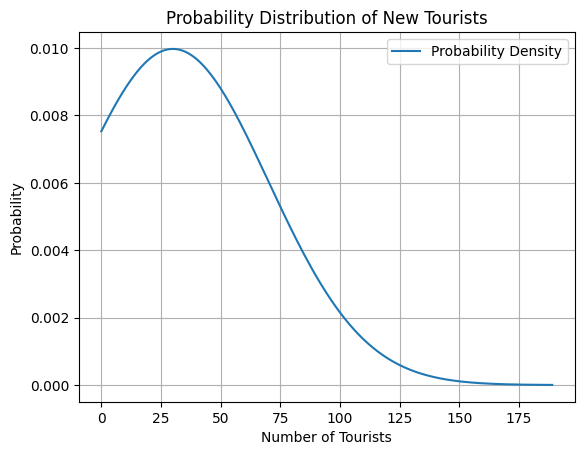

In [69]:

mean_rate=30
stddev_rate=40

x = np.arange(0, mean_rate + 4 * stddev_rate, 1)
y = (1 / (stddev_rate * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_rate) / stddev_rate) ** 2)
plt.plot(x, y, label="Probability Density")
plt.title("Probability Distribution of New Tourists")
plt.xlabel("Number of Tourists")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
inflow_season_1 = RandomTouristInflow(mean_rate=15, stddev_rate=25, mean_trip_length=30, stddev_trip_length=40)
inflow_season_2 = RandomTouristInflow(mean_rate=5, stddev_rate=5, mean_trip_length=15, stddev_trip_length=25)

# Define the corresponding season lengths
season_lengths = [30*2, 180-30*2]

# Create a SeasonalTouristInflow instance
seasonal_inflow = SeasonalTouristInflow(
    inflows=[inflow_season_1, inflow_season_2],
    season_lengths=season_lengths
)

cruise_ship = CruiseShipInflow(200, 2, 180)

inflows = UnionInflow([seasonal_inflow, cruise_ship])

In [71]:
starter_model=Model(nodes, graph, buildings, seasonal_inflow)
for i in range(360*2):
    starter_model.step()
    # if i > 360*2:
    #     for inflow in seasonal_inflow.inflows:
    #         inflow.mean_rate=-100
    if i % 30 == 0:
        for inflow in seasonal_inflow.inflows:
            inflow.mean_rate+=5

    if i % 30 == 0:
        starter_model.update_short_term_housing()


275
21
Activated ShortTermHousing 341055978 due to high fullness ratio.
Activated ShortTermHousing 344350882 due to high fullness ratio.
Activated ShortTermHousing 344350911 due to high fullness ratio.
Activated ShortTermHousing 345087979 due to high fullness ratio.
Activated ShortTermHousing 345090090 due to high fullness ratio.
Activated ShortTermHousing 345090092 due to high fullness ratio.
Activated ShortTermHousing 450914896 due to high fullness ratio.
Activated ShortTermHousing 450914898 due to high fullness ratio.
Activated ShortTermHousing 450914900 due to high fullness ratio.
Activated ShortTermHousing 450914904 due to high fullness ratio.
Activated ShortTermHousing 450914906 due to high fullness ratio.
Activated ShortTermHousing 450914910 due to high fullness ratio.
Activated ShortTermHousing 450914912 due to high fullness ratio.
Activated ShortTermHousing 450914913 due to high fullness ratio.
Activated ShortTermHousing 450914915 due to high fullness ratio.
Activated ShortTer

AttributeError: 'Model' object has no attribute 'calculate_revenue'

In [72]:
starter_model.graph

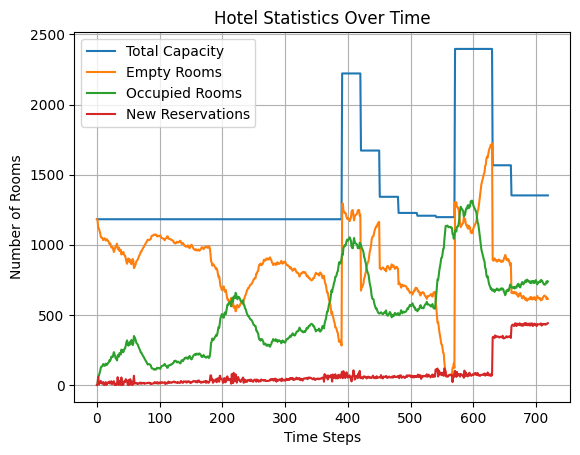

In [73]:
starter_model.plot_hotel_stats()

In [74]:
starter_model.poi_stats

[(7696, 7696, 0, 0),
 (7696, 7696, 0, 0),
 (7696, 7696, 0, 0),
 (7696, 7696, 0, 0),
 (7696, 7690, 6, 6),
 (7696, 7690, 6, 6),
 (7696, 7671, 25, 25),
 (7696, 7615, 81, 81),
 (7696, 7615, 81, 81),
 (7696, 7610, 86, 68),
 (7696, 7608, 88, 70),
 (7696, 7608, 88, 70),
 (7696, 7597, 99, 75),
 (7696, 7578, 118, 94),
 (7696, 7578, 118, 94),
 (7696, 7572, 124, 88),
 (7696, 7556, 140, 104),
 (7696, 7556, 140, 104),
 (7696, 7541, 155, 111),
 (7696, 7512, 184, 140),
 (7696, 7512, 184, 140),
 (7696, 7506, 190, 127),
 (7696, 7493, 203, 140),
 (7696, 7493, 203, 140),
 (7696, 7490, 206, 135),
 (7696, 7480, 216, 145),
 (7696, 7480, 216, 145),
 (7696, 7479, 217, 132),
 (7696, 7468, 228, 143),
 (7696, 7468, 228, 143),
 (7696, 7461, 235, 144),
 (7696, 7440, 256, 165),
 (7696, 7440, 256, 165),
 (7696, 7440, 256, 150),
 (7696, 7440, 256, 150),
 (7696, 7440, 256, 150),
 (7696, 7440, 256, 144),
 (7696, 7440, 256, 144),
 (7696, 7440, 256, 144),
 (7696, 7438, 258, 138),
 (7696, 7434, 262, 142),
 (7696, 7434, 26

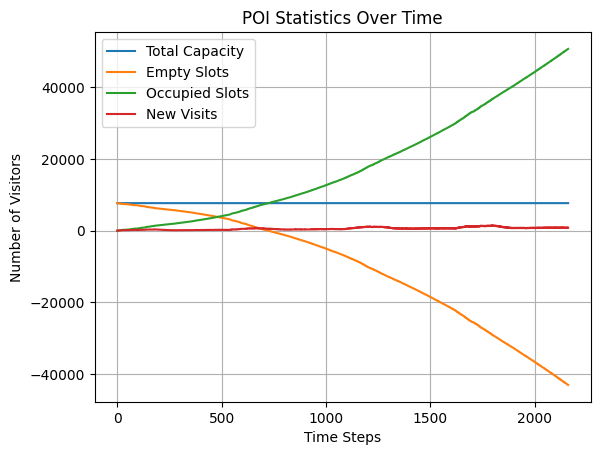

In [75]:
starter_model.plot_poi_stats()

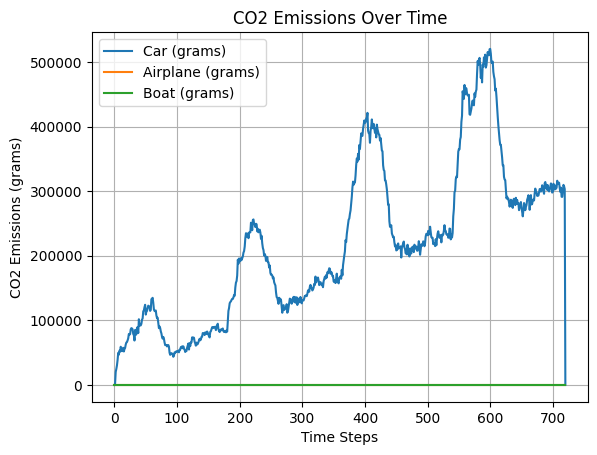

In [ ]:
starter_model.plot_co2_emissions()